##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Function Calling Router for Gemma-3: Implement and Monitor Agentic RAG workflow
<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/Gemma/[Gemma_3]Function_Calling_Routing_and_Monitoring_using_Gemma_Google_Genai.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Overview

**Gemma-3 natively doesn’t support Function calling at Inference** with Ollama or HuggingFace. Gemma-3 models pulled from the official Ollama registry do not advertise dedicated tool/function calling tags, and Ollama will return an error if requesting native tool support through direct means.​

### Our approach:

- Perform function calling by prompt engineering using delimiters hardcoded rather than by native tokens or system templates.
- Structured outputs and Agentic workflows are possible, but developers need to provide clear function definitions and parse model outputs for tool invocation details.

### Author Details
- **Author**: Tarun Jain
- **GitHub**: [@lucifertrj](https://github.com/lucifertrj)  
- **LinkedIn**: [@Tarun R Jain](http://linkedin.com/in/jaintarun75)


## Installation

In [ ]:
!pip install langgraph langchain-community
!pip install langchain-qdrant fastembed
!pip install pypdfium2
!pip install duckduckgo-search ddgs # custom function
!pip install opik # monitoring and tracing
!pip install langchain-google-genai  # gemma-3-27b-it

## Document processing

In [2]:
# data extraction and chunking
# my data is inside: a folder
# single file pdf
from langchain_community.document_loaders import FileSystemBlobLoader
from langchain_community.document_loaders.generic import GenericLoader
from langchain_community.document_loaders.parsers import PyPDFium2Parser

# embedding model
from langchain_community.embeddings import FastEmbedEmbeddings # sparse and dense (hybrid search)

# vector database dependency
from langchain_qdrant import FastEmbedSparse, QdrantVectorStore, RetrievalMode # hybrid
from qdrant_client import QdrantClient, models

### Data loading- Raw data extraction

With reference to this PDF Parser comparison paper, PDFium performs well on Financial documents. [arxiv.org/abs/2410.09871](https://arxiv.org/abs/2410.09871)

In [3]:
loader = GenericLoader(
    blob_loader=FileSystemBlobLoader(
        path="data",
        glob="*.pdf",
    ),
    blob_parser=PyPDFium2Parser(),
)

In [4]:
docs = loader.load()

In [5]:
len(docs)

3

In [6]:
docs[0].metadata

{'producer': 'Microsoft® Word LTSC',
 'creator': 'Microsoft® Word LTSC',
 'creationdate': '2025-07-23T13:00:52+05:30',
 'title': '',
 'author': 'aDMIN',
 'subject': '',
 'keywords': '',
 'moddate': '2025-07-23T13:00:52+05:30',
 'source': 'data/23AI5PCOTM-OTML.pdf',
 'total_pages': 3,
 'page': 0}

### Initialize Dense and Sparse Embeddings

In [ ]:
dense_embeddings = FastEmbedEmbeddings(model_name="jinaai/jina-embeddings-v2-base-en")
sparse_embeddings = FastEmbedSparse(model_name="Qdrant/bm25")

### Initialize your Vector database and config the collection- Hybrid Search

In [8]:
collection_name = "agenticrag"
client = QdrantClient(path="/tmp/db")

In [9]:
client.create_collection(
    collection_name = collection_name,
    vectors_config = {
        "dense1": models.VectorParams(size = 768,
                                     distance = models.Distance.COSINE
                                     )},
    sparse_vectors_config={
        "sparse1": models.SparseVectorParams(
            index = models.SparseIndexParams(on_disk=False),
            modifier = models.Modifier.IDF,
        )
    },
)

True

### Index your data

In [10]:
db = QdrantVectorStore(
    client = client,
    collection_name = collection_name,
    embedding = dense_embeddings,
    sparse_embedding = sparse_embeddings,
    retrieval_mode = RetrievalMode.HYBRID,
    vector_name = "dense1",
    sparse_vector_name = "sparse1",
)

In [11]:
from uuid import uuid4
uuids = [str(uuid4()) for _ in range(len(docs))]

In [12]:
db.add_documents(documents=docs, ids=uuids)

['df3ed049-d3a2-435d-aefd-097d1e90dff5',
 '8bcc0506-491a-462d-b5d3-c9cf867e6107',
 'ee11554a-7a8b-4802-9646-9c707cccb315']

In [13]:
!ls /tmp/db/collection/agenticrag

storage.sqlite


> Data is ingested, its time for the inference and building LangGraph nodes for Agentic RAG.

In [14]:
query = "module-2 content"
relevant_docs = db.similarity_search(query) # mmr: relevance + diversity

In [15]:
len(relevant_docs)

3

In [19]:
retriever = db.as_retriever(search_type="mmr",search_kwargs = {"k":3})

In [20]:
relevant_docs1 = retriever.invoke(query)

In [21]:
relevant_docs1[1].metadata

{'producer': 'Microsoft® Word LTSC',
 'creator': 'Microsoft® Word LTSC',
 'creationdate': '2025-07-23T13:00:52+05:30',
 'title': '',
 'author': 'aDMIN',
 'subject': '',
 'keywords': '',
 'moddate': '2025-07-23T13:00:52+05:30',
 'source': 'data/23AI5PCOTM-OTML.pdf',
 'total_pages': 3,
 'page': 0,
 '_id': 'df3ed049-d3a2-435d-aefd-097d1e90dff5',
 '_collection_name': 'agenticrag'}

## Agentic Setup: Answer Generation (Implement Function calling router)

Function calling lets you connect models to external tools and APIs. Instead of generating text responses, the model determines when to call specific functions and provides the necessary parameters to execute real-world actions. This allows the model to act as a bridge between natural language and real-world actions and data.

> Image credits: [https://ai.google.dev/gemini-api/docs/function-calling](https://ai.google.dev/gemini-api/docs/function-calling)

Our goal:
- Have 2 tools: Knowledge base and Web Search tool
- If query is from knowledge base, route to retrieve_docs tool
- If query is not from knowledge base, route to web_search tool

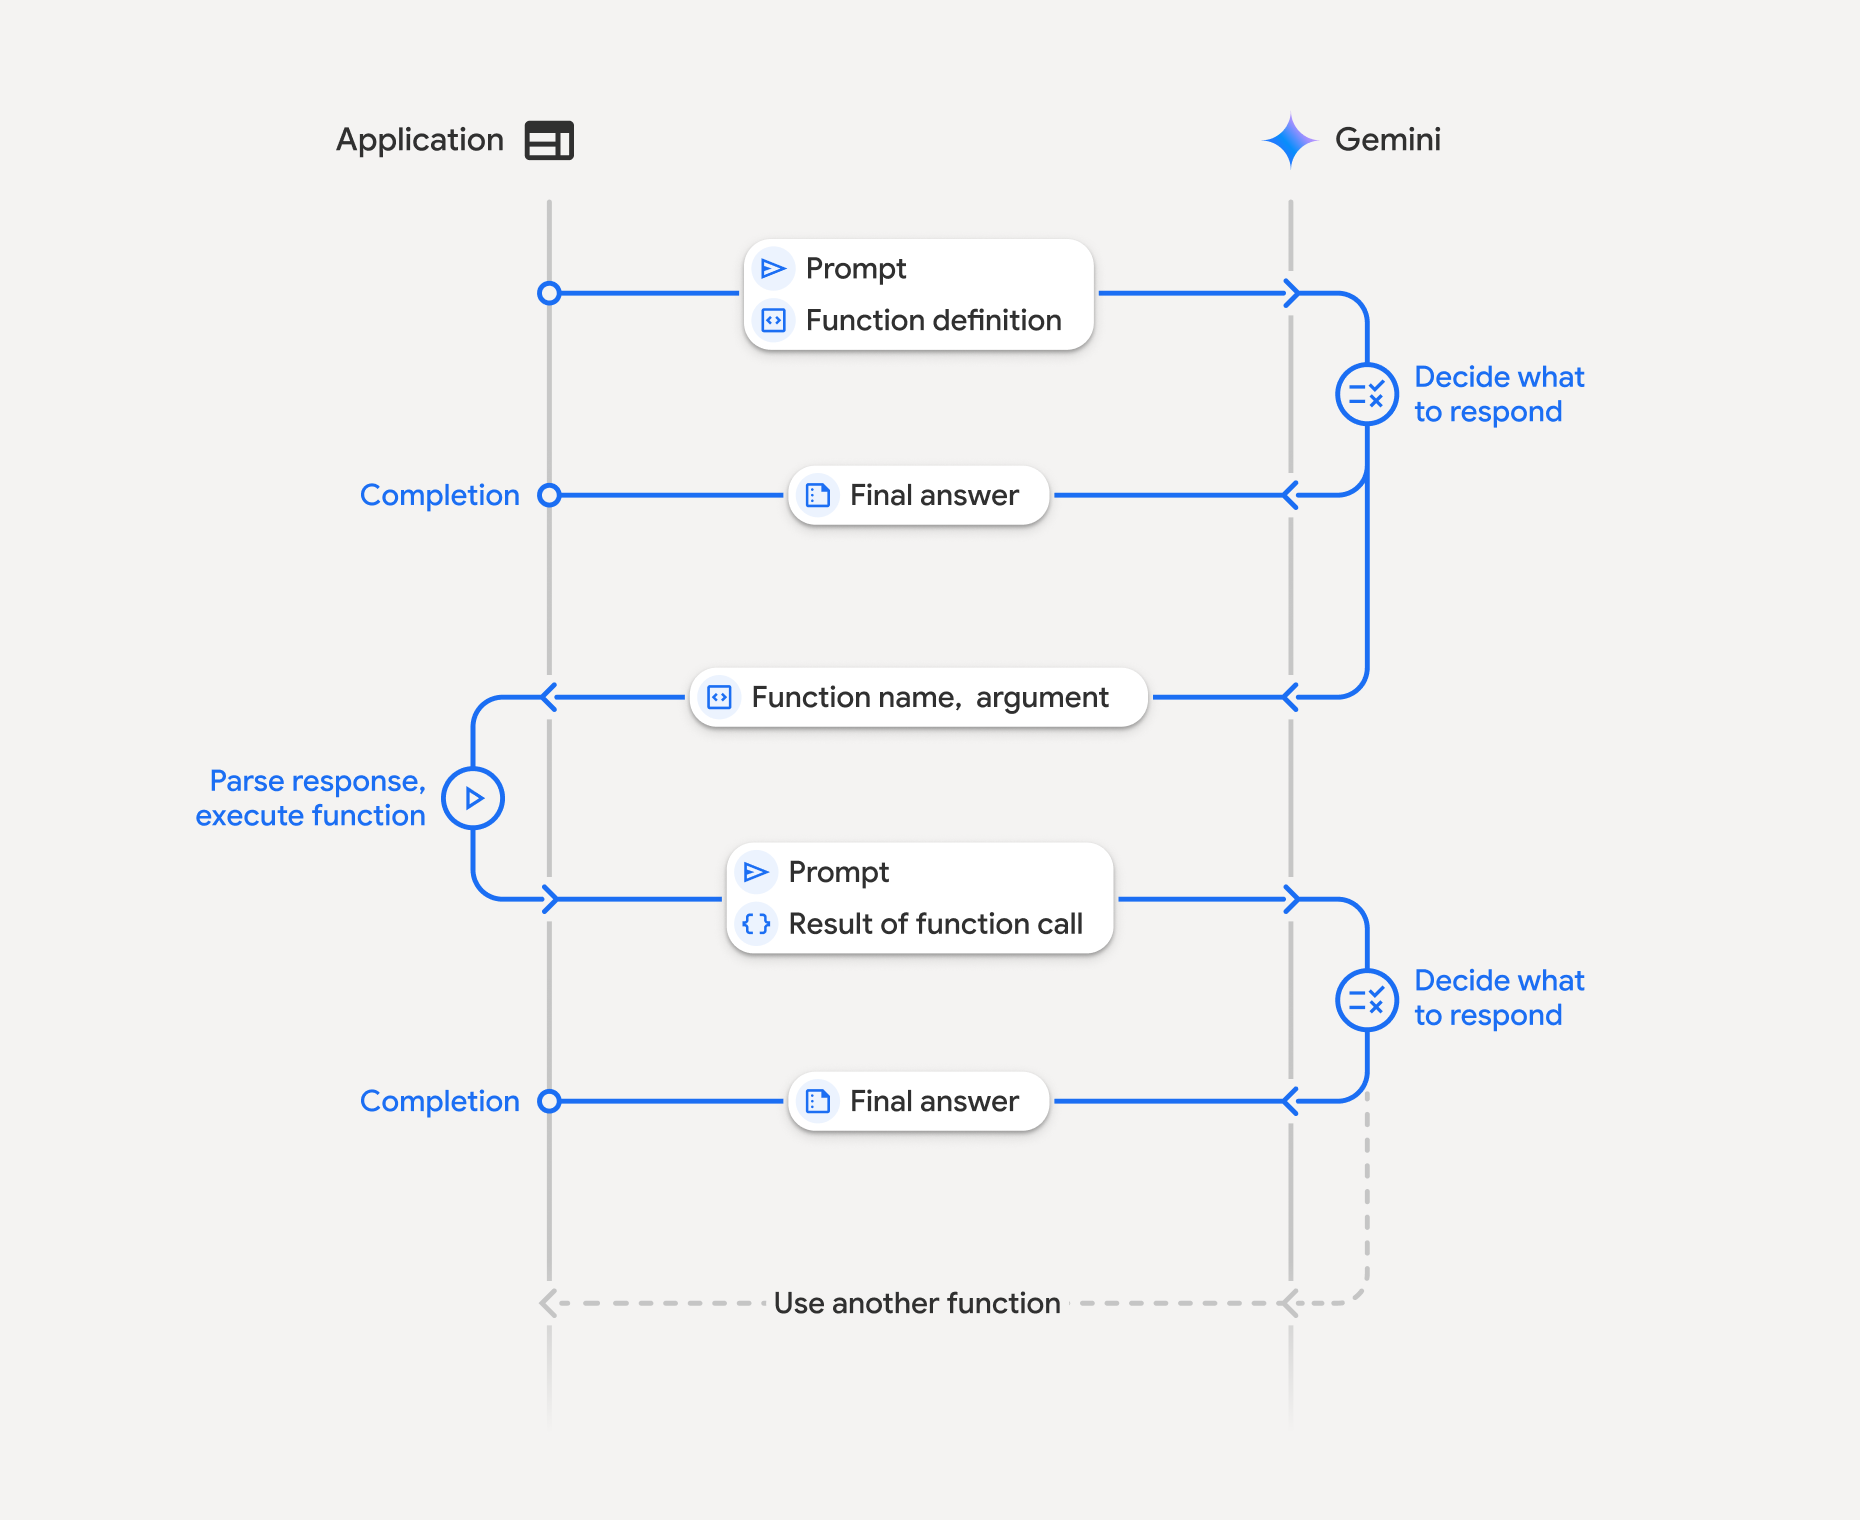

> Fig.1: Function calling workflow

## Tool-1: Knowledge base retriever:

Retrieve right document from the knowledge base.

In [22]:
def retrieve_docs(query:str) -> str:
  """
  retrieve relevant document from the knowledge base. use retrieve_docs function to get the results

  Args:
      query: user prompt to retrieve the context
  """
  response = retriever.invoke(query)
  context = [docs.page_content for docs in response]

  return "\n".join(context)

## Tool-2: Web Search

Get information from DuckDuckGo Search using the pre-defined tool kit from Langchain

In [26]:
def web_search(query:str) -> str:
    from langchain_community.tools import DuckDuckGoSearchRun

    """
    search results from the Google web browswer to the user query
    Args:
       query: user prompt
    """
    browse = DuckDuckGoSearchRun()
    context = browse.invoke(query)
    return context

## Execution: Execute the function tool logic

Our goal is to let LLM chose what function is right for the given user query and then call that function along with the required arguments and then execute that code in the runtime using the interpreter: ``eval()`` function.

In [25]:
def extract_tool_call(text):
    import io, re
    from contextlib import redirect_stdout

    pattern = r"```tool_code\s*(.*?)\s*```"
    match = re.search(pattern, text, re.DOTALL)
    if match:
        code = match.group(1).strip()
        f = io.StringIO()
        with redirect_stdout(f):
            result = eval(code)
        output = f.getvalue()
        r = result if output == '' else output
        return f'```tool_output\n{str(r).strip()}\n```'''
    return None

### LangGraph Implementation

We will use the same two above tools: retrieve_docs and web_search tool along with the execution tool to get context. This function calling workflow we will replicate using LangGraph as demonstrated in the previous about image, Fig.1.

In [27]:
import os
from google.colab import userdata
from google import genai

from langgraph.graph import StateGraph, START, END
from typing import TypedDict

## Get Credentials

- Get your OPIK API Key: [OPIK- Trace and Monitor](https://www.comet.com/signup?utm_source=workshop&utm_medium=partner&utm_campaign=tarun)
- Get your Gemini API Key: [Gemma-3-27b](https://aistudio.google.com/)

In [28]:
os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')
os.environ['OPIK_API_KEY'] = userdata.get("OPIK_API_KEY")
os.environ['OPIK_WORKSPACE'] = "tarun-r-jain"
os.environ['OPIK_PROJECT_NAME'] = "local-agentic-rag"

In [29]:
llm_client = genai.Client()

In [30]:
response = llm_client.models.generate_content(
    model="gemma-3-27b-it",
    contents="what is the capital of Germany?",
)

In [32]:
class AgentState(TypedDict):
    query: str
    context: str
    tool_response: str
    final_response: str

## Node-1: Given the user query, pick right tool

This is where we use the first LLM function call, where LLM decide for the given user task which is the right tool. We define the delimiters.
1. Send user message with instructions and function definitons and first user message.
2. Handle Model response when a tool/function is used using ```tool_code``` delimiters
3. Execute local function and create tool output string using execute_tool_call, the result should have ``tool_output`` delimiters.

In [34]:
def generate_tool_call_node(state: AgentState):
    query = state["query"]

    prompt = f'''
    You are expert router Agent, given the User Question, you need to pick relevant tools from the available Python methods only.
    At each turn, if you decide to invoke any of the function(s), it should be wrapped with ```tool_code```.
    The python methods described below are imported and available, you can only use defined methods.
    The generated code should be readable and efficient.
    The response to a method will be wrapped in ```tool_output``` use it to call more tools or generate a helpful, friendly response.
    When using a ```tool_call``` think step by step why and how it should be used.

    The following Python methods are available:

    ```python
    def retrieve_docs(query:str) -> str:
      """
      retrieve relevant document from the knowledge base. use retrieve_docs function to get the results
      Args:
          query: user prompt to retrieve the context
      """

    def web_search(query:str) -> str:
      """
      search results from the Google web browswer to the user query
      Args:
        query: user prompt
      """
    ```
    - retrieve_docs needs to be picked by default in case of confusion. Retrieve docs contains information on Tips and Tricks for Vibe coding
    - web_search: needs to be used if web search and information needs to be retrieved
    User: {query}
    '''

    tool_response = llm_client.models.generate_content(
        model="gemma-3-27b-it",
        contents=prompt,
    )
    return {"tool_response": tool_response.text}

## Node-2: Final Answer Generation

Once you get the context from the function call, generate the final results

In [33]:
def generate_final_answer_node(state: AgentState):
    query = state["query"]
    tool_response = state["tool_response"] # tool_code

    context = extract_tool_call(tool_response) # context

    final_prompt = f"""
    Answer the user question from the given CONTEXT.
    <context>
    CONTEXT: {context}
    </context>
    <question>
    User Question: {query}
    </question>
    """
    results = llm_client.models.generate_content(
        model="gemma-3-27b-it",
        contents=final_prompt,
    )
    return {"final_response": results.text,"context": context}

### Build Graph workflow

In [35]:
workflow = StateGraph(AgentState)
workflow.add_node("generate_tool_call", generate_tool_call_node)
workflow.add_node("generate_final_answer", generate_final_answer_node)

workflow.add_edge(START, "generate_tool_call")
workflow.add_edge("generate_tool_call", "generate_final_answer")
workflow.add_edge("generate_final_answer", END)

In [36]:
graph = workflow.compile()

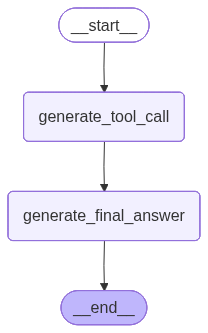

In [37]:
graph

In [38]:
result = graph.invoke({"query": "who is Messi?"})

In [39]:
print(result["final_response"])

Lionel Messi, full name Luis Lionel Andres Messi, is an Argentine professional soccer player widely regarded as one of the greatest of all time. He was born on June 24, 1987, in Rosario, Argentina, and displayed prodigious talent from a young age. He currently plays for Inter Miami and the Argentina national team. He has also played for FC Barcelona and Paris Saint-Germain.


In [41]:
print(result['tool_response']) # it used search

Okay, I understand. The user is asking a general knowledge question about Messi. Since this isn't related to Vibe coding specifically, I should use the `web_search` tool to find information about him.

```tool_code
web_search(query="who is Messi?")
```


In [42]:
print(result['context'])

```tool_output
Lionel Andrés " Leo " Messi [note 1] (Spanish: [ljoˈnel anˈdɾes ˈmesi] ⓘ; born 24 June 1987) is an Argentine professional footballer who plays as a forward for and captains both Major League Soccer club Inter Miami and the Argentina national team. Lionel Messi is an Argentine-born football (soccer) player who has been named the world’s best men’s player of the year seven times (2009–12, 2015, 2019, and 2021). In 2022 he helped Argentina win the World Cup. Naturally left-footed, quick, and precise in control of the ball, Messi is known as a keen pass distributor and can readily thread his way through packed defenses. What was Lionel Messi ’s childhood like? Lionel Messi started playing football as a boy and was noticed by clubs on both sides of the Atlantic. When he was 13, his family relocated to Barcelona. He played for FC Barcelona’s under-14 team, quickly graduating through the higher-level teams until his informal debut at age 16 with FC Barcelona in a friendly match

## Monitor

Log traces and spans, define and compute evaluation metrics, score LLM outputs, compare performance across app versions, and more.


In [43]:
from opik import track, opik_context

In [44]:
@track
def get_response(query):
  result = graph.invoke({"query":query})

  opik_context.update_current_trace(
      metadata={
          "tool_response": result['tool_response']
      }
  )

  return result['final_response']

In [45]:
get_response("who is Lionel Messi?")

OPIK: Started logging traces to the "local-agentic-rag" project at https://www.comet.com/opik/api/v1/session/redirect/projects/?trace_id=019a22ef-986d-723f-a438-7de883db61dc&path=aHR0cHM6Ly93d3cuY29tZXQuY29tL29waWsvYXBpLw==.


"Lionel Messi is an Argentine professional footballer who plays as a forward for and captains both Major League Soccer club Inter Miami and the Argentina national team. He is the national team's all-time leading goalscorer and most-capped player, and has won eight Ballon d'Or awards, the most for any footballer. He was born on June 24, 1987. He also won a gold medal at the 2008 Summer Olympics and has won 45 team trophies."

You can use the above OPIK URL and access the dashboard that will track, trace and monitor the performance of the LLM calls.